In [2]:
import pandas as pd
from sklearn.utils import resample
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
seed = 1

In [3]:
file_path = 'data.csv'
# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)
# Display the first few rows of the DataFrame to verify the data has been loaded correctly
data.head()

,Unnamed: 0,X,CODE_N,COMMUNE,BVQ_N,POPSDC99,LOG,LOGVAC,STRATLOG,surf_m2,lat_centre,lon_centre
0,1,1,31001,AGASSAC,31239,121,65,9,1,9511618,43.372490,0.886155
1,2,2,31002,AIGNES,31033,193,99,7,1,22017258,43.334563,1.586608
2,3,3,31003,AIGREFEUILLE,31044,577,179,1,2,4608949,43.569188,1.585158
3,4,4,31004,AYGUESVIVES,31582,1815,656,15,3,13328942,43.428642,1.594306
4,5,5,31005,ALAN,31028,299,163,9,2,11439648,43.219979,0.927076


In [4]:
# Calculate the true mean of the column "LOG"
true_mean = data['LOG'].mean()
print(f"True mean: {true_mean}")

True mean: 353.108


## SRSWOR

In [5]:
np.random.seed(seed)
N = len(data)
# Number of simulations
n_simulations = 10000
# Sample size for each simulation
sample_size = 100

# Empty list to store the estimates from each simulation
estimates = []

for _ in range(n_simulations):
    # Sample without replacement
    sample = resample(data['LOG'], replace=False, n_samples=sample_size)
    # Calculate the HT estimator for the sample mean
    ht_estimator = sample.mean()
    # Store the estimate
    estimates.append(ht_estimator)

# Calculate the mean square error
mse_SRSWOR = np.mean([(x - true_mean) ** 2 for x in estimates])
mean_estimate_SRSWOR = np.mean(estimates)

print(f"Estimate: {mean_estimate_SRSWOR:.3f}")
print(f"MSE: {mse_SRSWOR:.3f}")

Estimate: 352.509
MSE: 2520.397


## Bernoulli Sampling

In [5]:
np.random.seed(seed)
# Bernoulli sampling function
def bernoulli_sampling(data, sample_size):
    # Generate a mask for selection with the same probability for each item
    probabilities = np.full(len(data), sample_size / len(data))
    # Draw samples using the Bernoulli distribution
    selected = np.random.binomial(1, probabilities).astype(bool)
    return data[selected]

# Run the Monte Carlo simulation with Bernoulli sampling
bernoulli_estimates = []

for _ in range(n_simulations):
    # Bernoulli sample
    sample = bernoulli_sampling(data['LOG'], sample_size)
    # Calculate the HT estimator for the sample mean
    ht_estimator = sample.mean()
    # Store the estimate
    bernoulli_estimates.append(ht_estimator)

# Calculate the mean square error for Bernoulli sampling
mse_bernoulli = np.mean([(x - true_mean)**2 for x in bernoulli_estimates])
mean_estimate_bernoulli = np.mean(bernoulli_estimates)
re_bernoulli = 100*(mse_bernoulli / mse_SRSWOR)

print(f"Estimate: {mean_estimate_bernoulli:.3f}")
print(f"MSE: {mse_bernoulli:.3f}")
print(f"Relative efficiency: {re_bernoulli:.3f}")

Estimate: 352.078
MSE: 2517.749
Relative efficiency: 99.895


## Systematic Sampling

In [6]:
np.random.seed(seed)
# Systematic sampling function
def systematic_sampling(data, sample_size):
    # Determine the sampling interval
    interval = len(data) // sample_size
    # Random start within the first interval
    start = np.random.randint(0, interval)
    # Select elements with a fixed interval
    indices = np.arange(start, len(data), interval)
    return data.iloc[indices]

# Run the Monte Carlo simulation with Systematic sampling
systematic_estimates = []

for _ in range(n_simulations):
    # Systematic sample
    sample = systematic_sampling(data['LOG'], sample_size)
    # Calculate the HT estimator for the sample mean
    ht_estimator_systematic = sample.mean()
    # Store the estimate
    systematic_estimates.append(ht_estimator_systematic)

# Calculate the mean square error for Systematic sampling
mse_systematic = np.mean([(x - true_mean)**2 for x in systematic_estimates])
mean_estimate_systematic = np.mean(systematic_estimates)
re_systematic = 100*(mse_systematic / mse_SRSWOR)

print(f"Estimate: {mean_estimate_systematic:.3f}")
print(f"MSE: {mse_systematic:.3f}")
print(f"Relative efficiency: {re_systematic:.3f}")

Estimate: 353.281
MSE: 2116.191
Relative efficiency: 83.963


## Systematic Sampling (Ordering the data)

Reordering the data based on the data in column 'POPSDC99'

In [6]:
np.random.seed(seed)
# Sorting 'data' based on the values in the "LOG" column
data_ordered = data.sort_values(by='POPSDC99')

# Systematic sampling function
def systematic_sampling(data, sample_size):
    # Determine the sampling interval
    interval = len(data) // sample_size
    # Random start within the first interval
    start = np.random.randint(0, interval)
    # Select elements with a fixed interval
    indices = np.arange(start, len(data), interval)
    return data.iloc[indices]

# Run the Monte Carlo simulation with Systematic sampling
systematic_estimates = []

for _ in range(n_simulations):
    # Systematic sample
    sample = systematic_sampling(data_ordered['LOG'], sample_size)
    # Calculate the HT estimator for the sample mean
    ht_estimator_systematic = sample.mean()
    # Store the estimate
    systematic_estimates.append(ht_estimator_systematic)

# Calculate the mean square error for Systematic sampling
mse_systematic = np.mean([(x - true_mean)**2 for x in systematic_estimates])
mean_estimate_systematic = np.mean(systematic_estimates)
re_systematic = 100*(mse_systematic / mse_SRSWOR)

print(f"Estimate: {mean_estimate_systematic:.3f}")
print(f"MSE: {mse_systematic:.3f}")
print(f"Relative efficiency: {re_systematic:.3f}")

Estimate: 353.106
MSE: 203.470
Relative efficiency: 8.073


## Systematic Sampling (Unequal inclusion probability)

The inclusion probability is based on the data in column 'POPSDC99'

$\pi_k = \frac{n x_k}{\sum_{x \in u} x_k}$ 

In [8]:
def systematic_sampling(probabilities, sample_size):
    # Calculate the cumulative sum of the probabilities
    cum_prob = np.cumsum(probabilities)
    # Generate a random start from 0 to the interval length
    interval = 1.0 / sample_size
    start = np.random.uniform(0, interval)
    # Determine the systematic sample indexes
    indexes = []
    for i in range(sample_size):
        indexes.append(np.where(cum_prob >= start + interval * i)[0][0])
    return indexes

# Function to run Monte Carlo simulation with Systematic Sampling
def monte_carlo_systematic_sampling(data, sample_size, N, num_simulations):
    systematic_ht_estimates = []
    for _ in tqdm(range(num_simulations)):
        # Calculate inclusion probabilities based on 'POPSDC99'
        x_k = data['POPSDC99']
        sum_x_k = x_k.sum()
        pi_k = (sample_size * x_k) / sum_x_k

        # Perform systematic sampling based on cumulative inclusion probabilities
        sample_indices = systematic_sampling(pi_k, sample_size)
        sampled_data = data.iloc[sample_indices]

        # Calculate the HT estimator for the mean µ̂_π
        mu_hat_pi = (sampled_data['LOG'] / pi_k.iloc[sample_indices]).sum() / N
        systematic_ht_estimates.append(mu_hat_pi)

    # Calculate the estimated mean and MSE over the simulations
    mean_estimate_systematic = np.mean(systematic_ht_estimates)
    mse_systematic = np.mean((np.array(systematic_ht_estimates) - true_mean) ** 2)
    
    return mean_estimate_systematic, mse_systematic

# Run the simulation
mean_estimate_systematic, mse_systematic = monte_carlo_systematic_sampling(data, sample_size, len(data), 10000)
re_systematic = 100*(mse_systematic / mse_SRSWOR)

print(f"Estimate: {mean_estimate_systematic:.3f}")
print(f"MSE: {mse_systematic:.3f}")
print(f"Relative efficiency: {re_systematic:.3f}")

100%|██████████| 10000/10000 [00:23<00:00, 426.00it/s]

Estimate: 387.523
MSE: 1190.184
Relative efficiency: 47.222


## Stratified sampling (Proportional Allocation)

The strata size calculation is based on the data in column 'STRATLOG' (4 stratum)

$\frac{n_h}{N_h} = \frac{n}{N}$

In [9]:
np.random.seed(seed)  
# Adjusted stratified sampling function using proportional allocation to use HT estimator
def stratified_sampling_proportional(data, strata_col, target_col, total_sample_size):
    grouped_data = data.groupby(strata_col)
    N = len(data)  # Total population size
    stratum_proportions = grouped_data.size() / N
    stratum_sample_sizes = np.round(stratum_proportions * total_sample_size).astype(int)
    stratum_sizes = grouped_data.size()

    ht_estimates = []
    for stratum, group in grouped_data:
        stratum_sample_size = stratum_sample_sizes[stratum]
        if stratum_sample_size > 0:  # Ensure we have a positive sample size
            stratum_sample = group[target_col].sample(n=stratum_sample_size, replace=False, random_state=np.random.randint(0, 10000))
            stratum_mean = stratum_sample.mean()
            weight = stratum_sizes[stratum] / N
            ht_estimate = weight * stratum_mean
            ht_estimates.append(ht_estimate)

    # Sum over all strata to get the overall HT estimator
    ht_mu_pi = sum(ht_estimates)
    return ht_mu_pi

# Adjusted Monte Carlo simulation using the stratified sampling with HT estimator
stratified_ht_estimates_proportional = []

for _ in tqdm(range(n_simulations)):
    ht_mu_pi = stratified_sampling_proportional(data, 'STRATLOG', 'LOG', sample_size)
    stratified_ht_estimates_proportional.append(ht_mu_pi)

# Calculate the mean and MSE of the HT estimates
mean_estimate_stratified_proportional = np.mean(stratified_ht_estimates_proportional)
mse_stratified_proportional = np.mean([(estimate - true_mean) ** 2 for estimate in stratified_ht_estimates_proportional])
re_stratified_proportional = 100*(mse_stratified_proportional / mse_SRSWOR)

print(f"Estimate: {mean_estimate_stratified_proportional:.3f}")
print(f"MSE: {mse_stratified_proportional:.3f}")
print(f"Relative efficiency: {re_stratified_proportional:.3f}")

100%|██████████| 10000/10000 [00:08<00:00, 1143.88it/s]

Estimate: 353.251
MSE: 542.217
Relative efficiency: 21.513


## Stratified sampling (Optimal Allocation)

The strata size calculation is based on the data in column 'POPSDC99' (4 stratum)

$n_h = \frac{n N_h S_{xh}}{\sum_{h \in [H] N_h S_{xh}}}$

In [11]:
# Stratify 'LOG' into 4 strata based on 'POPSDC99'
data['stratum'] = pd.qcut(data['POPSDC99'], q=4, labels=False)

# Calculate stratum weights 
stratum_weights = data.groupby('stratum')['POPSDC99'].count() / N

# Calculate stratum standard deviations 
stratum_std = data.groupby('stratum')['POPSDC99'].std()

# Calculate optimal sample size for each stratum using the provided formula
optimal_n_h = (sample_size * stratum_weights * stratum_std) / (stratum_weights * stratum_std).sum()

# Ensure that the sum of the stratum sample sizes is equal to the total sample size
optimal_n_h = optimal_n_h.round().astype(int)
optimal_n_h.iloc[-1] = sample_size - optimal_n_h.iloc[:-1].sum()

# Function to perform stratified sampling and calculate HT estimator
def stratified_ht_estimator_simulation(data, stratum_weights, optimal_n_h, N):
    ht_estimates = []

    # Loop over each stratum
    for stratum, n_h in optimal_n_h.items():
        # Draw a sample from each stratum
        stratum_data = data[data['stratum'] == stratum]
        sample = stratum_data.sample(n=n_h, replace=False)
        
        # Calculate stratum mean ȳ_h
        stratum_mean = sample['LOG'].mean()
        
        # Calculate stratum's contribution to HT estimator
        ht_contribution = (stratum_weights[stratum] * stratum_mean)
        ht_estimates.append(ht_contribution)
    
    # Sum contributions from each stratum to get the HT estimator
    mu_hat_pi = sum(ht_estimates)
    
    return mu_hat_pi

# Run the Monte Carlo simulation
stratified_ht_estimates = [stratified_ht_estimator_simulation(data, stratum_weights, optimal_n_h, N) for _ in tqdm(range(10000))]

# Calculate the estimated mean and MSE over the simulations
mean_estimate_stratified_optimal = np.mean(stratified_ht_estimates)
mse_stratified_optimal = np.mean((np.array(stratified_ht_estimates) - true_mean) ** 2)
re_stratified_optimal = 100*(mse_stratified_optimal / mse_SRSWOR)

print(f"Estimate: {mean_estimate_stratified_optimal:.3f}")
print(f"MSE: {mse_stratified_optimal:.3f}")
print(f"Relative efficiency: {re_stratified_optimal:.3f}")

100%|██████████| 10000/10000 [00:06<00:00, 1621.36it/s]

Estimate: 353.231
MSE: 421.355
Relative efficiency: 16.718


## Poisson sampling

The inclusion probability is based on the data in column 'POPSDC99'

$\pi_k = \frac{n x_k}{\sum_{x \in u} x_k}$ 

In [12]:
# using 'POPSDC99' for inclusion probabilities
def ht_estimator_simulation(data, n_exp, N):
    # Inclusion probabilities for each unit based on 'POPSDC99'
    x_k = data['POPSDC99']
    sum_x_k = x_k.sum()
    pi_k = (n_exp * x_k) / sum_x_k

    # Draw a sample using these inclusion probabilities
    sample_indices = np.random.choice(data.index, size=n_exp, replace=False, p=pi_k/pi_k.sum())
    sampled_data = data.loc[sample_indices]

    # Calculate the HT estimator for the mean µ̂_π
    mu_hat_pi = (sampled_data['LOG'] / pi_k[sample_indices]).sum() / N
    
    return mu_hat_pi


# Run the Monte Carlo simulation
ht_estimates = [ht_estimator_simulation(data, sample_size, N) for _ in tqdm(range(10000))]

# Calculate the estimated mean and MSE over the simulations
mean_estimate_poisson = np.mean(ht_estimates)
mse_poisson = np.mean((np.array(ht_estimates) - true_mean) ** 2)
re_poisson = 100 * (mse_poisson / mse_SRSWOR)

# Print the results
print(f"Estimate: {mean_estimate_poisson:.3f}")
print(f"MSE: {mse_poisson:.2f}")
print(f"Relative efficiency: {re_poisson:.2f}")

100%|██████████| 10000/10000 [00:03<00:00, 2633.03it/s]

Estimate: 365.029
MSE: 339.01
Relative efficiency: 13.45


## The linearity between 'POPSDC99' and 'LOG'

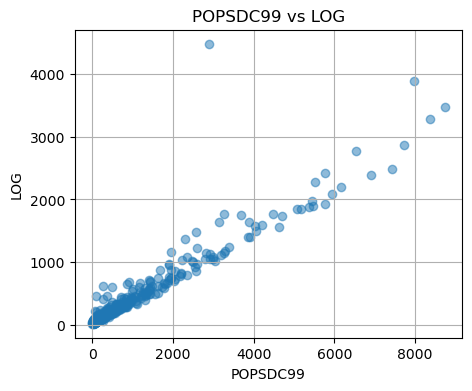

In [21]:
# Scatter plot of POPSDC99 vs LOG
plt.figure(figsize=(5, 4))
plt.scatter(data['POPSDC99'], data['LOG'], alpha=0.5)
plt.title('POPSDC99 vs LOG')
plt.xlabel('POPSDC99')
plt.ylabel('LOG')
plt.grid(True)
plt.show()

## Results

- SRSWOR
    - MSE: 2520.397
- Bernoulli Sampling
    - MSE: 2517.749
    - Relative efficiency: 99.895
- Systematic Sampling
    - MSE: 2116.191
    - Relative efficiency: 83.963
- Systematic Sampling (Ordering the data)
    - MSE: 203.470
    - Relative efficiency: 8.073
- Systematic Sampling (Unequal inclusion probability)
    - MSE: 1190.184
    - Relative efficiency: 47.222
- Stratified sampling (Proportional Allocation)
    - MSE: 542.217
    - Relative efficiency: 21.513
- Stratified sampling (Optimal Allocation)
    - MSE: 421.355
    - Relative efficiency: 16.718
- Poisson sampling
    - MSE: 339.01
    - Relative efficiency: 13.45


## Analysis

- **Simple Random Sampling Without Replacement (SRSWOR)**: 
    - Serving as the baseline for comparison, SRSWOR has an MSE of 2520.397. It is a versatile method, but not the most efficient in the presence of structure or variability within the population.

- **Bernoulli Sampling**: 
    - Very similar in MSE to SRSWOR, which implies nearly identical performance in terms of variance and bias. The RE close to 100% suggests it's nearly as efficient as SRSWOR under the conditions tested.

- **Systematic Sampling**: 
    - Offers a significant improvement over SRSWOR and Bernoulli sampling in terms of MSE, suggesting a more consistent estimator. The RE indicates it's more efficient than SRSWOR by about 16%.

- **Systematic Sampling (Ordering the Data)**: 
    - This design drastically reduces the MSE, indicating a highly effective method for this particular dataset, especially if the data's order correlates with the value being estimated. The RE of 8.073% indicates an exceptional increase in efficiency, potentially due to reduced variance within systematic intervals. The ordering also benefits from the good linear relationship between data in column 'LOG' and 'POPSDC99' since we don't have the full knowledge of the population

- **Systematic Sampling (Unequal Inclusion Probability)**: 
    - Shows improvement over the base SRSWOR but not as dramatic as when ordering is considered. It suggests that adjusting for unequal probabilities can improve efficiency, but perhaps not as effectively as when the data exhibits a natural or induced order.

- **Stratified Sampling (Proportional Allocation)**: 
    - This significantly reduces the MSE compared to SRSWOR, highlighting the advantage of stratification when population subgroups are more homogenous than the overall population. The RE indicates a considerable improvement in efficiency.

- **Stratified Sampling (Optimal Allocation)**: 
    - Further improves on proportional allocation by minimizing MSE, showcasing the benefit of allocating more samples to strata with greater variability. And it is also due to the good linear relationship between data in column 'LOG' and 'POPSDC99' .The improvement in RE underscores the importance of stratification in achieving efficient estimations.

- **Poisson Sampling**: 
    - Exhibits the lowest MSE among the methods tested, indicating highly accurate and reliable estimations. The relatively high RE suggests that leveraging the variability within the population to guide sampling can significantly enhance efficiency. The good result also benefits from the good linear relationship between data in column 'LOG' and 'POPSDC99'

## Conclusion

The efficiency and accuracy of sampling designs can vary significantly depending on the characteristics of the population and the specifics of each method. Systematic sampling, particularly when data ordering is considered, and stratified sampling, especially with optimal allocation, have shown substantial improvements in estimation accuracy and efficiency over simple random sampling. Poisson sampling also enhances efficiency by effectively leveraging population variability. 

The strong linear relationship between the data in columns 'LOG' and 'POPSDC99' significantly impacts the effectiveness of the sampling designs evaluated, particularly in those methods that leverage this relationship to enhance sampling efficiency and estimation accuracy. This underscores the importance of a good choice of auxiliary variable when implementing sampling design.